# Applying Sentence Transformers to Political Speech - Predicting Sentiment Scores
### POLI 179 Project - Brenna Farris and Eden Stewart

Further examining this research: https://doi.org/10.1080/10584609.2021.1952497

Data accessed from: https://github.com/ccochrane/emotionTranscripts

GitHub Repo of Project: https://github.com/bafarris/speech-sentiment-bilstm

## Loading Libraries and Dataset

In [4]:
# import libraries
import numpy as np
import pandas as pd
import random
import requests
from io import BytesIO
from zipfile import ZipFile
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# set random seeds
np.random.seed(88)
random.seed(88)
tf.random.set_seed(88)

In [6]:
# load dataset (contains human coder sentiment scores and segments of corpus)
full_df = pd.read_csv(
    'https://raw.githubusercontent.com/bafarris/speech-sentiment-bilstm/main/data/w2vScores.csv',
    sep=','
)

# examine dataset
print(full_df.head())
rows = full_df.shape[0]
print(f"Number of rows: {rows}")
columns = full_df.shape[1]
print(f"Number of columns: {columns}")

   Unnamed: 0        IDMain  countedWords        date  \
0           0  2017 12 13 0            13  2017-12-13   
1           1  2017 12 13 1             8  2017-12-13   
2           2  2017 12 13 2            16  2017-12-13   
3           3  2017 12 13 3            30  2017-12-13   
4           4  2017 12 13 4             7  2017-12-13   

                                             english  \
0  I thought we usually hired an investigator to ...   
1  I hope they will be getting better than that i...   
2  We told Canadians that we would run deficits, ...   
3  The problem was that they fired 700 people in ...   
4  We did not create the Phoenix problem, but we ...   

                                               floor  french  label party  \
0  Moi, je pensais qu'on embauchait d'habitude un...       1      1   NDP   
1  I hope they will be getting better than that i...       0      2   LIB   
2  We told Canadians that we would run deficits, ...       0      3   LIB   
3  The probl

In [7]:
# find minimum and maximum number in 'sentiment' column
min_sentiment = full_df['sentiment'].min()
max_sentiment = full_df['sentiment'].max()

# find range
range_sentiment = max_sentiment - min_sentiment

# examine results
print(f"Minimum sentiment score: {min_sentiment}")
print(f"Maximum sentiment score: {max_sentiment}")
print(f"Range of sentiment scores: {range_sentiment}")

Minimum sentiment score: -1.240414334860232
Maximum sentiment score: 2.362722101791796
Range of sentiment scores: 3.603136436652028


## Pre-Processing

In [8]:
# load stop words
stop_words = set(stopwords.words('english'))

# tokenize (lowercase, split text into words, remove stop words)
def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

# apply preprocessing to 'english' column (contains corpus segments)
full_df['tokens'] = full_df['english'].apply(preprocess_text)

# prepare sentences for word2vec
sentences = full_df['tokens'].tolist()

# train word2vec model
word2vec_model_sample = Word2Vec(sentences, vector_size=300, window=6, min_count=10, epochs=5)

# save model
word2vec_model_sample.save("word2vec_sample.model")

# print model vocabulary
print(word2vec_model_sample.wv.key_to_index)

{'minister': 0, 'speaker': 1, 'government': 2, 'canadians': 3, 'canada': 4, 'prime': 5, 'canadian': 6, 'work': 7, 'would': 8, 'liberals': 9, 'house': 10, 'people': 11, 'jobs': 12, 'new': 13, 'member': 14, 'us': 15, 'tax': 16, 'support': 17, 'members': 18, 'public': 19, 'plan': 20, 'going': 21, 'like': 22, 'get': 23, 'make': 24, 'know': 25, 'liberal': 26, 'one': 27, 'help': 28, 'working': 29, 'families': 30, 'said': 31, 'conservatives': 32, 'communities': 33, 'put': 34, 'national': 35, 'quebec': 36, 'also': 37, 'process': 38, 'country': 39, 'health': 40, 'years': 41, 'finance': 42, 'continue': 43, 'important': 44, 'year': 45, 'bill': 46, 'ensure': 47, 'take': 48, 'every': 49, 'commissioner': 50, 'need': 51, 'money': 52, 'across': 53, 'yesterday': 54, 'million': 55, 'system': 56, 'economy': 57, 'access': 58, 'ndp': 59, 'want': 60, 'last': 61, 'trade': 62, 'question': 63, 'conservative': 64, 'future': 65, 'many': 66, 'budget': 67, 'way': 68, 'women': 69, 'first': 70, 'indigenous': 71, 'ma

## Sentence Transformers

In [9]:
# load SentenceTransformer model with 'all-MiniLM-L6-v2' configuration
model = SentenceTransformer('all-MiniLM-L6-v2')

# encode 'english' column of dataframe 'full_df' into embeddings, convert them into tensors
embeddings = model.encode(full_df['english'].tolist(), convert_to_tensor=True)

# split the embeddings and sentiment data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, full_df['sentiment'], test_size=0.2, random_state=88)

# initialize linear regression model
regressor = LinearRegression()

# fit the linear regression model on training data
regressor.fit(X_train, y_train)

# predict sentiment on test data
y_pred = regressor.predict(X_test)

# calculate mse between predicted and actual sentiment values
mse = mean_squared_error(y_test, y_pred)

# print mse
print(f"Mean Squared Error: {mse}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Mean Squared Error: 0.12438798708888445


In [10]:
# load SentenceTransformer model with 'all-MiniLM-L6-v2' configuration
model = SentenceTransformer('all-MiniLM-L6-v2')

# encode 'english' column of dataframe 'full_df' into embeddings, and convert into tensors
embeddings = model.encode(full_df['english'].tolist(), convert_to_tensor=True)

# split embeddings and sentiment data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, full_df['sentiment'], test_size=0.2, random_state=88)

# initialize linear regression model
regressor = LinearRegression()

# fit linear regression model on training data
regressor.fit(X_train, y_train)

# predict sentiment on test data
y_pred = regressor.predict(X_test)

# set threshold for binarizing
threshold = 0.5

# binarize predictions by reshaping and applying threshold
y_pred_bin = binarize(y_pred.reshape(-1,1), threshold=threshold)[:,0]

# convert y_test to a numpy array, reshape it, and binarize it
y_test_bin = binarize(y_test.to_numpy().reshape(-1,1), threshold=threshold)[:,0]

# calculate accuracy score binarized
accuracy = accuracy_score(y_test_bin, y_pred_bin)

# calculate F1 score binarized
f1 = f1_score(y_test_bin, y_pred_bin, average='weighted')

# print accuracy score
print(f"Accuracy: {accuracy}")

# print F1 score
print(f"F1 Score: {f1}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Accuracy: 0.8333333333333334
F1 Score: 0.8491125856395317


## Visualize Results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

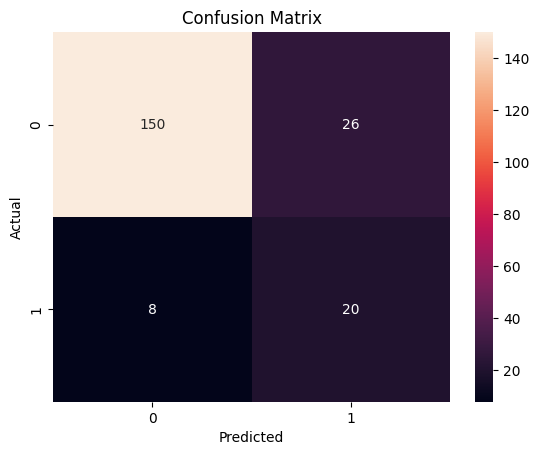

In [14]:
# calculate confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin)

# plot confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt='d')

# add a title to plot
plt.title('Confusion Matrix')

# label x-axis as 'predicted'
plt.xlabel('Predicted')

# label y-axis as 'actual'
plt.ylabel('Actual')

# download plot file
plt.savefig('sentiment_scores_cm_st.png')
files.download('sentiment_scores_cm_st.png')

# display plot
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

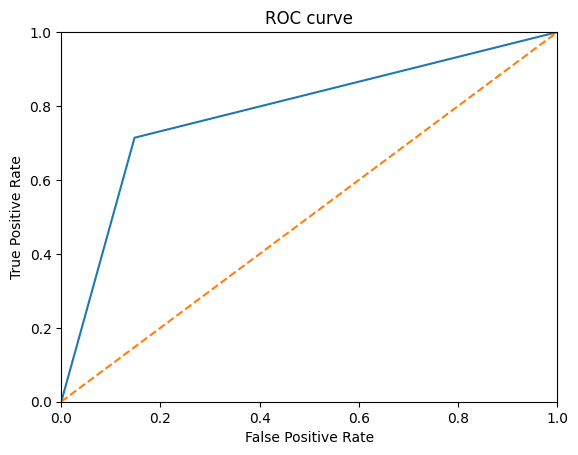

In [15]:
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)

# plot ROC curve
plt.plot(fpr, tpr)

# plot diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--')

# set x-axis limits
plt.xlim([0.0, 1.0])

# set y-axis limits
plt.ylim([0.0, 1.0])

# add a title to plot
plt.title('ROC curve')

# label x-axis as 'false positive rate'
plt.xlabel('False Positive Rate')

# label y-axis as 'true positive rate'
plt.ylabel('True Positive Rate')

# download plot file
plt.savefig('sentiment_scores_roc_st.png')
files.download('sentiment_scores_roc_st.png')

# display plot
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

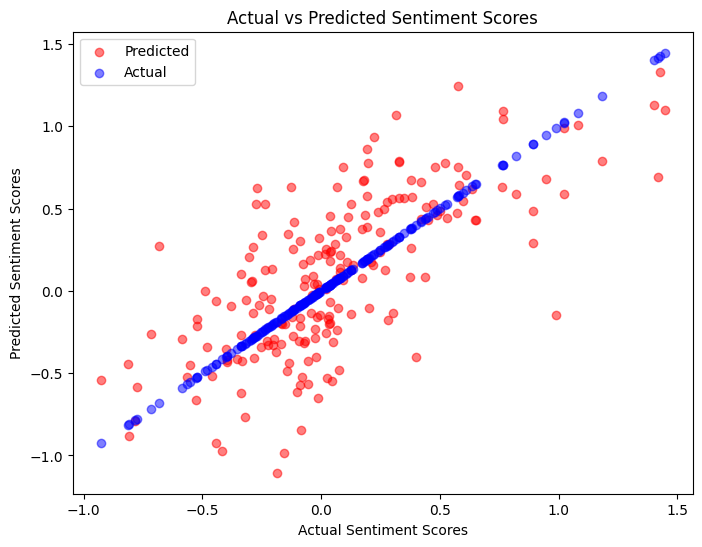

In [16]:
# create a figure for the plot with size 8x6 inches
plt.figure(figsize=(8, 6))

# plot predicted sentiment scores as red scatter points
plt.scatter(y_test, y_pred, alpha=0.5, color='red')

# plot actual sentiment scores as blue scatter points
plt.scatter(y_test, y_test, alpha=0.5, color='blue')

# label x-axis as 'actual sentiment scores'
plt.xlabel('Actual Sentiment Scores')

# label y-axis as 'predicted sentiment scores'
plt.ylabel('Predicted Sentiment Scores')

# add a title to plot
plt.title('Actual vs Predicted Sentiment Scores')

# add a legend to plot
plt.legend(['Predicted', 'Actual'])

# download plot file
plt.savefig('sentiment_scores_scatter_st.png')
files.download('sentiment_scores_scatter_st.png')

# display plot
plt.show()